In [1]:
import torch
from torch.utils.data import Dataset
from torch.nn import functional as F
from torchvision import transforms
from torch.optim import AdamW

from diffusers import AutoencoderKL, UNet2DConditionModel, StableDiffusionPipeline, DDIMScheduler
from transformers import CLIPTokenizer, CLIPTextModel

from peft import LoraConfig, get_peft_model
from bitsandbytes.optim import AdamW8bit


from PIL import Image, ImageOps
import gc
import os
from tqdm.auto import tqdm

# model_id = "stabilityai/stable-diffusion-2-1"
model_id = "stabilityai/stable-diffusion-2-base"
torch_device = "cuda"

In [2]:
def load_models(model_id, model_name, lora):
    from peft import PeftModel
    if lora is None:
        raise Exception("lora should not be None")

    if lora:
        new_unet = UNet2DConditionModel.from_pretrained(model_id, subfolder="unet")
        new_unet = PeftModel.from_pretrained(new_unet, f"../experiments/{model_name}/unet")

        new_text = CLIPTextModel.from_pretrained(model_id, subfolder="text_encoder")
        new_text = PeftModel.from_pretrained(new_text, f"../experiments/{model_name}/text_encoder")
    else:
        new_unet = UNet2DConditionModel.from_pretrained(f"../experiments/{model_name}", subfolder="unet")
        new_text = CLIPTextModel.from_pretrained(f"../experiments/{model_name}", subfolder="text_encoder")

    pipe = StableDiffusionPipeline.from_pretrained(model_id,
                                                   unet=new_unet,
                                                   text_encoder=new_text)
    return pipe

def save_images(images, model_name):
    if not os.path.exists(f"../experiments/{model_name}/images"):
        os.makedirs(f"../experiments/{model_name}/images")  
    for i in range(len(images)):
        images[i].save(f"../experiments/{model_name}/images/img_{i}.jpg")

In [3]:
model_name = "misha_lora_best"
pipe = load_models(model_id, model_name, lora=True)
pipe = pipe.to(torch_device)

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Expected types for unet: (<class 'diffusers.models.unets.unet_2d_condition.UNet2DConditionModel'>,), got <class 'peft.peft_model.PeftModel'>.
Expected types for text_encoder: (<class 'transformers.models.clip.modeling_clip.CLIPTextModel'>,), got <class 'peft.peft_model.PeftModel'>.


In [4]:
def set_seed(seed=4): # to be reproducible
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

class_of_obj = "dog"
prompts = [f"sks {class_of_obj} in a field of roses",
           f"sks {class_of_obj} pooping",
           f"sks {class_of_obj} catching a frisbee while in air",
           f"sks {class_of_obj} playing with another dog",
           f"sks {class_of_obj} being an angel and flying over a city"
]
images = []
for pr in prompts:
    set_seed(1)
    with torch.no_grad():
        images.append(pipe(pr).images[0])

# save_images(images,model_name)


  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/50 [00:00<?, ?it/s]

sks dog in a field of roses


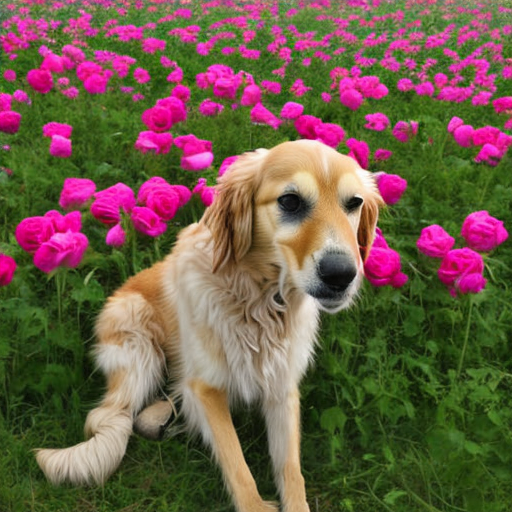

In [11]:
# to see the result. 

i=0
print(prompts[i])
images[i]